# Edge detection

In [25]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split

from augmentators import randomHueSaturationValue, randomHorizontalFlip, randomShiftScaleRotate
from u_net import get_unet_128

sys.path.append("../")
from ycb_video import CONFIG, dataset

## Parameters

In [18]:
orig_shape = (128, 128, 3)
input_shape = (128, 128, 3)
batch_size = 1
epochs = 50

## Load dataset

In [19]:
X_paths, _, Y_paths = dataset.load()

## Process images

In [20]:
def process_sample_and_label(img_path: str, mask_path: str) -> tuple[np.ndarray, np.ndarray]:
    img = cv2.imread(img_path)
    img = cv2.resize(img, input_shape[:2])
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, input_shape[:2])
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-50, 50),
                                   sat_shift_limit=(-5, 5),
                                   val_shift_limit=(-15, 15))
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.25, 0.25),
                                       scale_limit=(-0.3, 0.3),
                                       rotate_limit=(-10, 10))
    img, mask = randomHorizontalFlip(img, mask)
    mask = np.expand_dims(mask, axis=2)
    return img, mask


In [21]:
X = []
Y = []
for x, y in zip(X_paths, Y_paths):
    x_path = f"{CONFIG['images_path']}/{x}"
    y_path = f"{CONFIG['images_path']}/{y}"
    img, mask = process_sample_and_label(x_path, y_path)
    X.append(img)
    Y.append(mask)
X = np.array(X, np.float32) / 255
Y = np.array(Y, np.float32) / 255


## Split into train and test

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10)

print('Training on {} samples'.format(len(X_train)))
print('Validating on {} samples'.format(len(X_test)))

Training on 285 samples
Validating on 32 samples


## Build model

In [23]:
train_generator = dataset.batch_generator(X_train, Y_train, batch_size)
valid_generator = dataset.batch_generator(X_test, Y_test, batch_size)

callbacks = [
    #        EarlyStopping(monitor='val_dice_loss',
    #                           patience=8,
    #                           verbose=1,
    #                           min_delta=1e-4,
    #                           mode='max'),
    ReduceLROnPlateau(monitor='val_dice_loss',
                      factor=0.5,
                      patience=4,
                      verbose=1,
                      min_delta=1e-5,
                      mode='max'),
    ModelCheckpoint(monitor='val_dice_loss',
                    filepath='weights/best_weights.hdf5',
                    save_best_only=True,
                    save_weights_only=True,
                    mode='max'),
    TensorBoard(log_dir='logs')]

model = get_unet_128(input_shape)


## Train

In [27]:
load_weights = True
if load_weights:
    model.load_weights("weights/best_weights.hdf5")
else:
    hist = model.fit(train_generator,
                    steps_per_epoch=np.ceil(len(X_train) / batch_size),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator,
                    validation_steps=np.ceil(len(X_test) / batch_size))


## Test

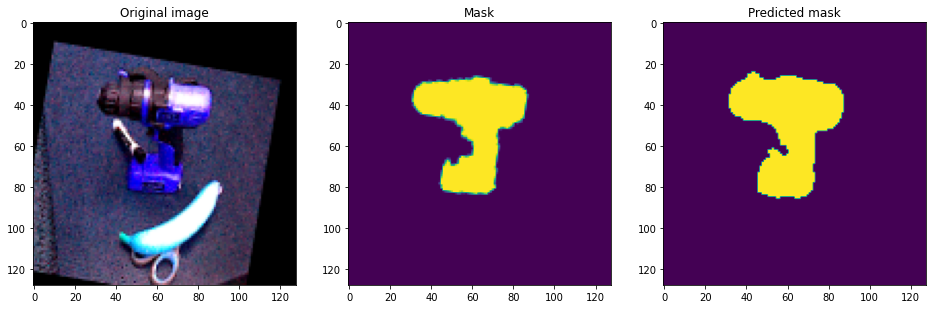

In [30]:
threshold = 0.5
imgs, masks = next(valid_generator)

preds = model.predict_on_batch(imgs)
preds = np.squeeze(preds, axis=3)

img = imgs[0]
mask = masks[0]
pred = preds[0]

prob = np.array(cv2.resize(pred, orig_shape[:2]) > threshold).astype(np.float32) * 255
# Display image
plt.figure(figsize=(16, 9))
plt.subplot(131)
plt.imshow(img)
plt.title("Original image")
plt.subplot(132)
plt.imshow(mask)
plt.title("Mask")
plt.subplot(133)
plt.imshow(prob)
plt.title("Predicted mask")
plt.show()